In [1]:
# Author: Keval Pipalia
# McGill ID: 261164851
# Contact: keval.pipalia@mail.mcgill.ca

# Notes for Grader:
# Please note that all of the dependencies are managed with poetry, if you are unable to regenerate results, please let me know i can share my project config files.
# Data is under `./data/` folder, it is uncompressed first and then loaded, so its not in gzip.
# Thanks and have a wonderful day.

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#  Load and Prepare the Data
csv_path = 'data/MIMIC3_DIAGNOSES_ICD_subset.csv'

# Load the dataset
data = pd.read_csv(csv_path)
# Count unique patients and diagnoses
total_patients = data['SUBJECT_ID'].nunique()
total_diagnoses = data['ICD9_CODE'].nunique()

# Remap SUBJECT_ID and ICD9_CODE to sequential integers
data['PatientIdx'] = data['SUBJECT_ID'].astype('category').cat.codes
data['IcdIdx'] = data['ICD9_CODE'].astype('category').cat.codes

# Q1: Implementing collapsed Gibbs sampling LDA (5%)

In [4]:
# Initialize Variables and hyper params for LDA
num_topics = 5  # number of topics
alpha = 1.0     # Hyperparameter alpha
beta = 0.001     # Hyperparameter beta
num_iterations = 100  # Number of iterations for Gibbs Sampling
num_docs = len(data)

In [5]:
# Assingning initial random topics
data['Topic'] = np.random.randint(0, num_topics, len(data))

In [6]:
data

,SUBJECT_ID,ICD9_CODE,PatientIdx,IcdIdx,Topic
0,17843,2851,163,63,2
1,10152,389,96,6,0
2,15311,4280,140,113,0
3,45434,5070,392,132,3
4,32229,51881,349,287,0
...,...,...,...,...,...
995,26042,5849,254,153,1
996,83875,486,601,13,1
997,50391,29410,409,225,0
998,25030,78039,238,341,2


In [7]:
# Initialize count matrices
doc_topic_count = np.zeros((total_patients, num_topics), dtype = int)
word_topic_count = np.zeros((total_diagnoses, num_topics), dtype = int)

In [8]:
# Updating the counts according to random topic assignments
for index, vals in data.iterrows():
    patient_idx = vals['PatientIdx']
    icd_idx = vals['IcdIdx']
    topic = vals['Topic']

    # decrease the count
    doc_topic_count[patient_idx][topic] += 1
    word_topic_count[icd_idx][topic] += 1

In [9]:
# Actual Iterations
for _ in range(num_iterations):
    z_id = np.zeros([num_docs, num_topics])
    for index, vals in data.iterrows():
        patient_idx = vals['PatientIdx']
        icd_idx = vals['IcdIdx']
        topic = vals['Topic']

        # Decrement by 1
        doc_topic_count[patient_idx][topic] -= 1
        word_topic_count[icd_idx][topic] -= 1

        # Calculating gamma 
        gamma = np.multiply((alpha + doc_topic_count[patient_idx]), (beta + word_topic_count[icd_idx])/((beta * total_diagnoses) + np.sum(word_topic_count, axis=0)))

        # Calculating probabilities
        pval = gamma/np.sum(gamma)
        z_id[index] = pval

        # Increment with 1
        doc_topic_count[patient_idx][topic] += 1
        word_topic_count[icd_idx][topic] += 1
        
    for i in range(num_docs):
        data.at[i, "Topic"] = np.random.multinomial(1, z_id[i]).argmax()

    # Updating the counts according to new topic assignments
    for index, vals in data.iterrows():
        patient_idx = vals['PatientIdx']
        icd_idx = vals['IcdIdx']
        topic = vals['Topic']
    
        # decrease the count
        doc_topic_count[patient_idx][topic] += 1
        word_topic_count[icd_idx][topic] += 1

    # Calculate phi and theta, Normalize to get distribution
    phi = (beta + word_topic_count) / ((total_diagnoses * beta) + np.sum(word_topic_count, axis=0))
    theta = (alpha + doc_topic_count) / ((num_topics * alpha) + np.sum(doc_topic_count, axis=1)).reshape((689, 1)) # reshaping to avoid value error for broadcast.

# Q2: Visualizing the top ICD codes under each topic (1%)

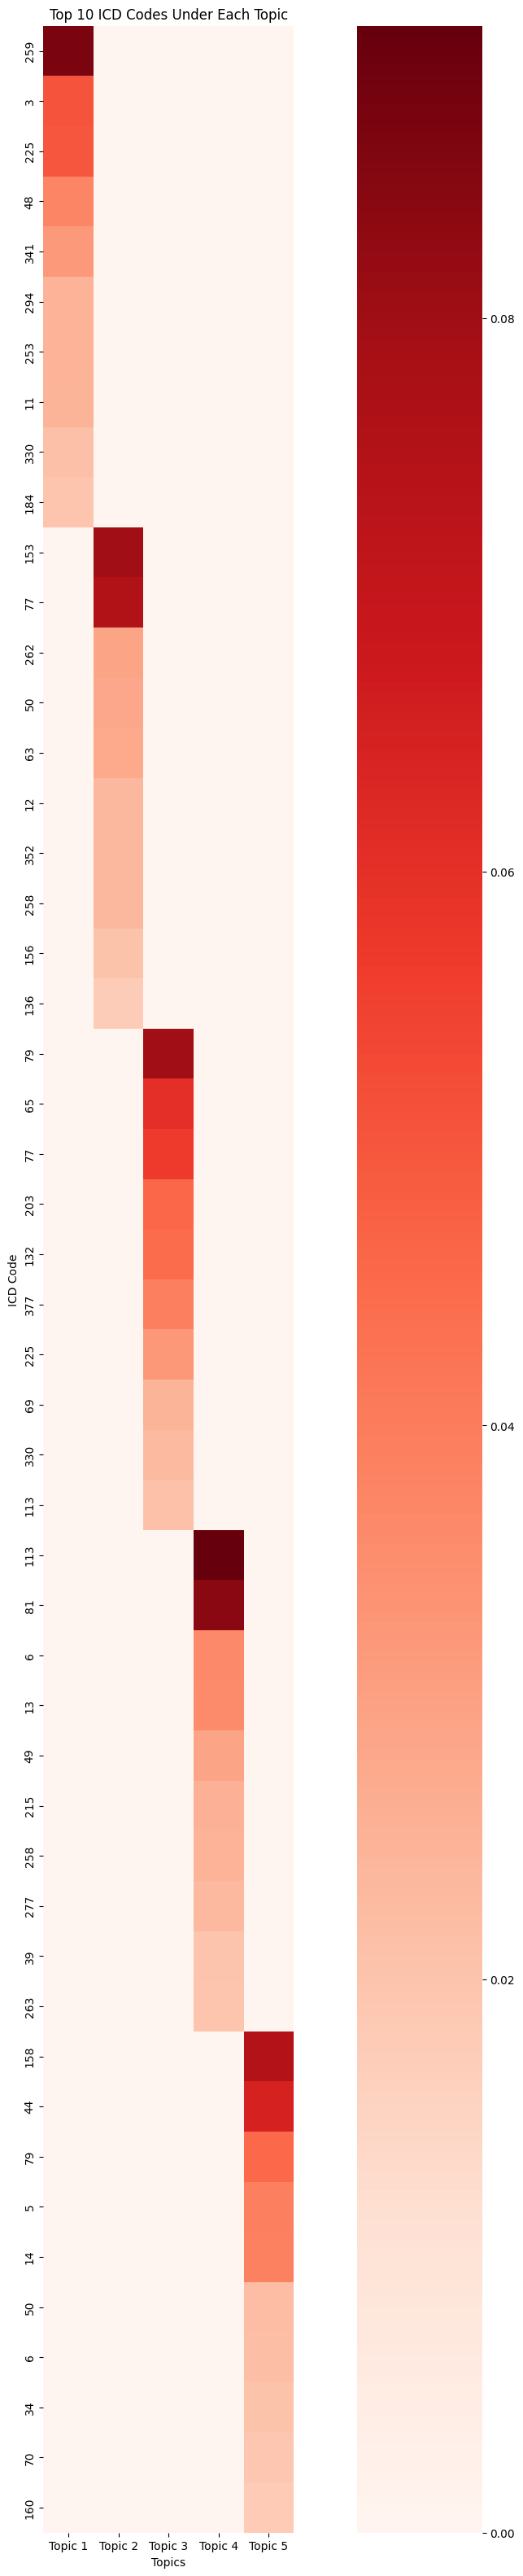

In [10]:
phi_df = pd.DataFrame(phi, columns=["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5"])

# Collect the top 10 entries for each topic
top_phi_dfs = [phi_df.nlargest(10, column) for column in phi_df.columns]

# Concatenate all the top entries into a single DataFrame
top_phi_df = pd.concat(top_phi_dfs)

# Setting other entries to zero for better vizualization of top 10 icd per topic
for i in range(1, 6):
    top_phi_df.iloc[10*i:, :i] = 0
    top_phi_df.iloc[:10*i, i:] = 0

# Visualization
plt.figure(figsize=(20, 40))
ax = sns.heatmap(top_phi_df, cmap="Reds", square=True, fmt=".2f")
plt.title('Top 10 ICD Codes Under Each Topic')
plt.xlabel('Topics')
plt.ylabel('ICD Code')
plt.show()

# Q3: Correlating topics with the target ICD codes (1%)

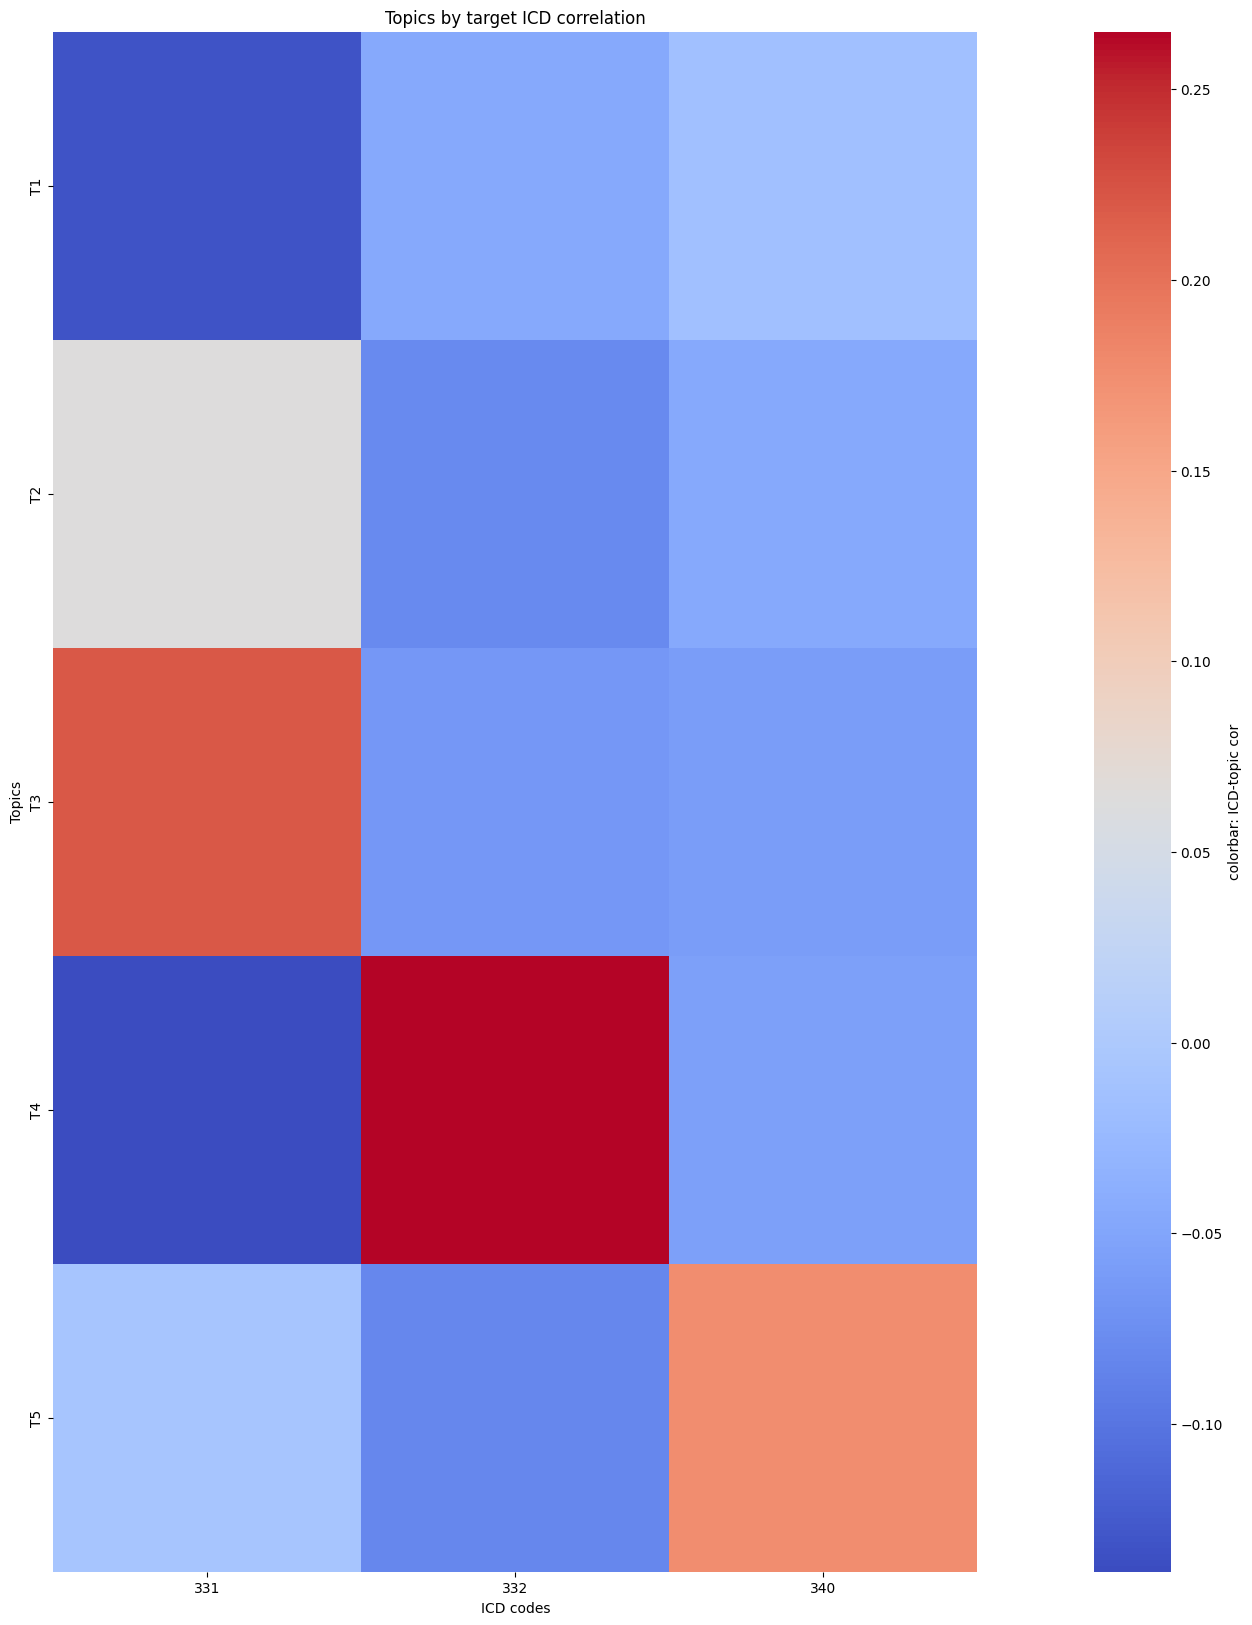

In [11]:
def extract_icd_indicator(data, icd_prefixes):
    indicator_matrix = np.zeros((data['PatientIdx'].nunique(), len(icd_prefixes)), dtype=int)

    for index, row in data.iterrows():
        patient_idx = row['PatientIdx']
        icd_code = str(row['ICD9_CODE'])
        for i, prefix in enumerate(icd_prefixes):
            if icd_code.startswith(prefix):
                indicator_matrix[patient_idx, i] = 1

    return pd.DataFrame(indicator_matrix, columns=icd_prefixes)

def calculate_correlation(topic_df, icd_df):
    correlation_data = []
    for topic in topic_df.columns:
        correlations = [topic_df[topic].corr(icd_df[icd_code]) for icd_code in icd_df.columns]
        correlation_data.append(correlations)

    return pd.DataFrame(correlation_data, index=topic_df.columns, columns=icd_df.columns)

icd_prefixes = ["331", "332", "340"]
topic_columns = ["T1", "T2", "T3", "T4", "T5"]

theta_df = pd.DataFrame(theta, columns=topic_columns)
icd_indicator_df = extract_icd_indicator(data, icd_prefixes)
correlation_df = calculate_correlation(theta_df, icd_indicator_df)

# Plotting the heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_df, cmap="coolwarm", square=True, cbar_kws={'label': 'colorbar: ICD-topic cor'})
plt.xlabel('ICD codes')
plt.ylabel('Topics')
plt.title('Topics by target ICD correlation')
plt.show()

# Q4: Visualizing patient topic mixtures (1%)

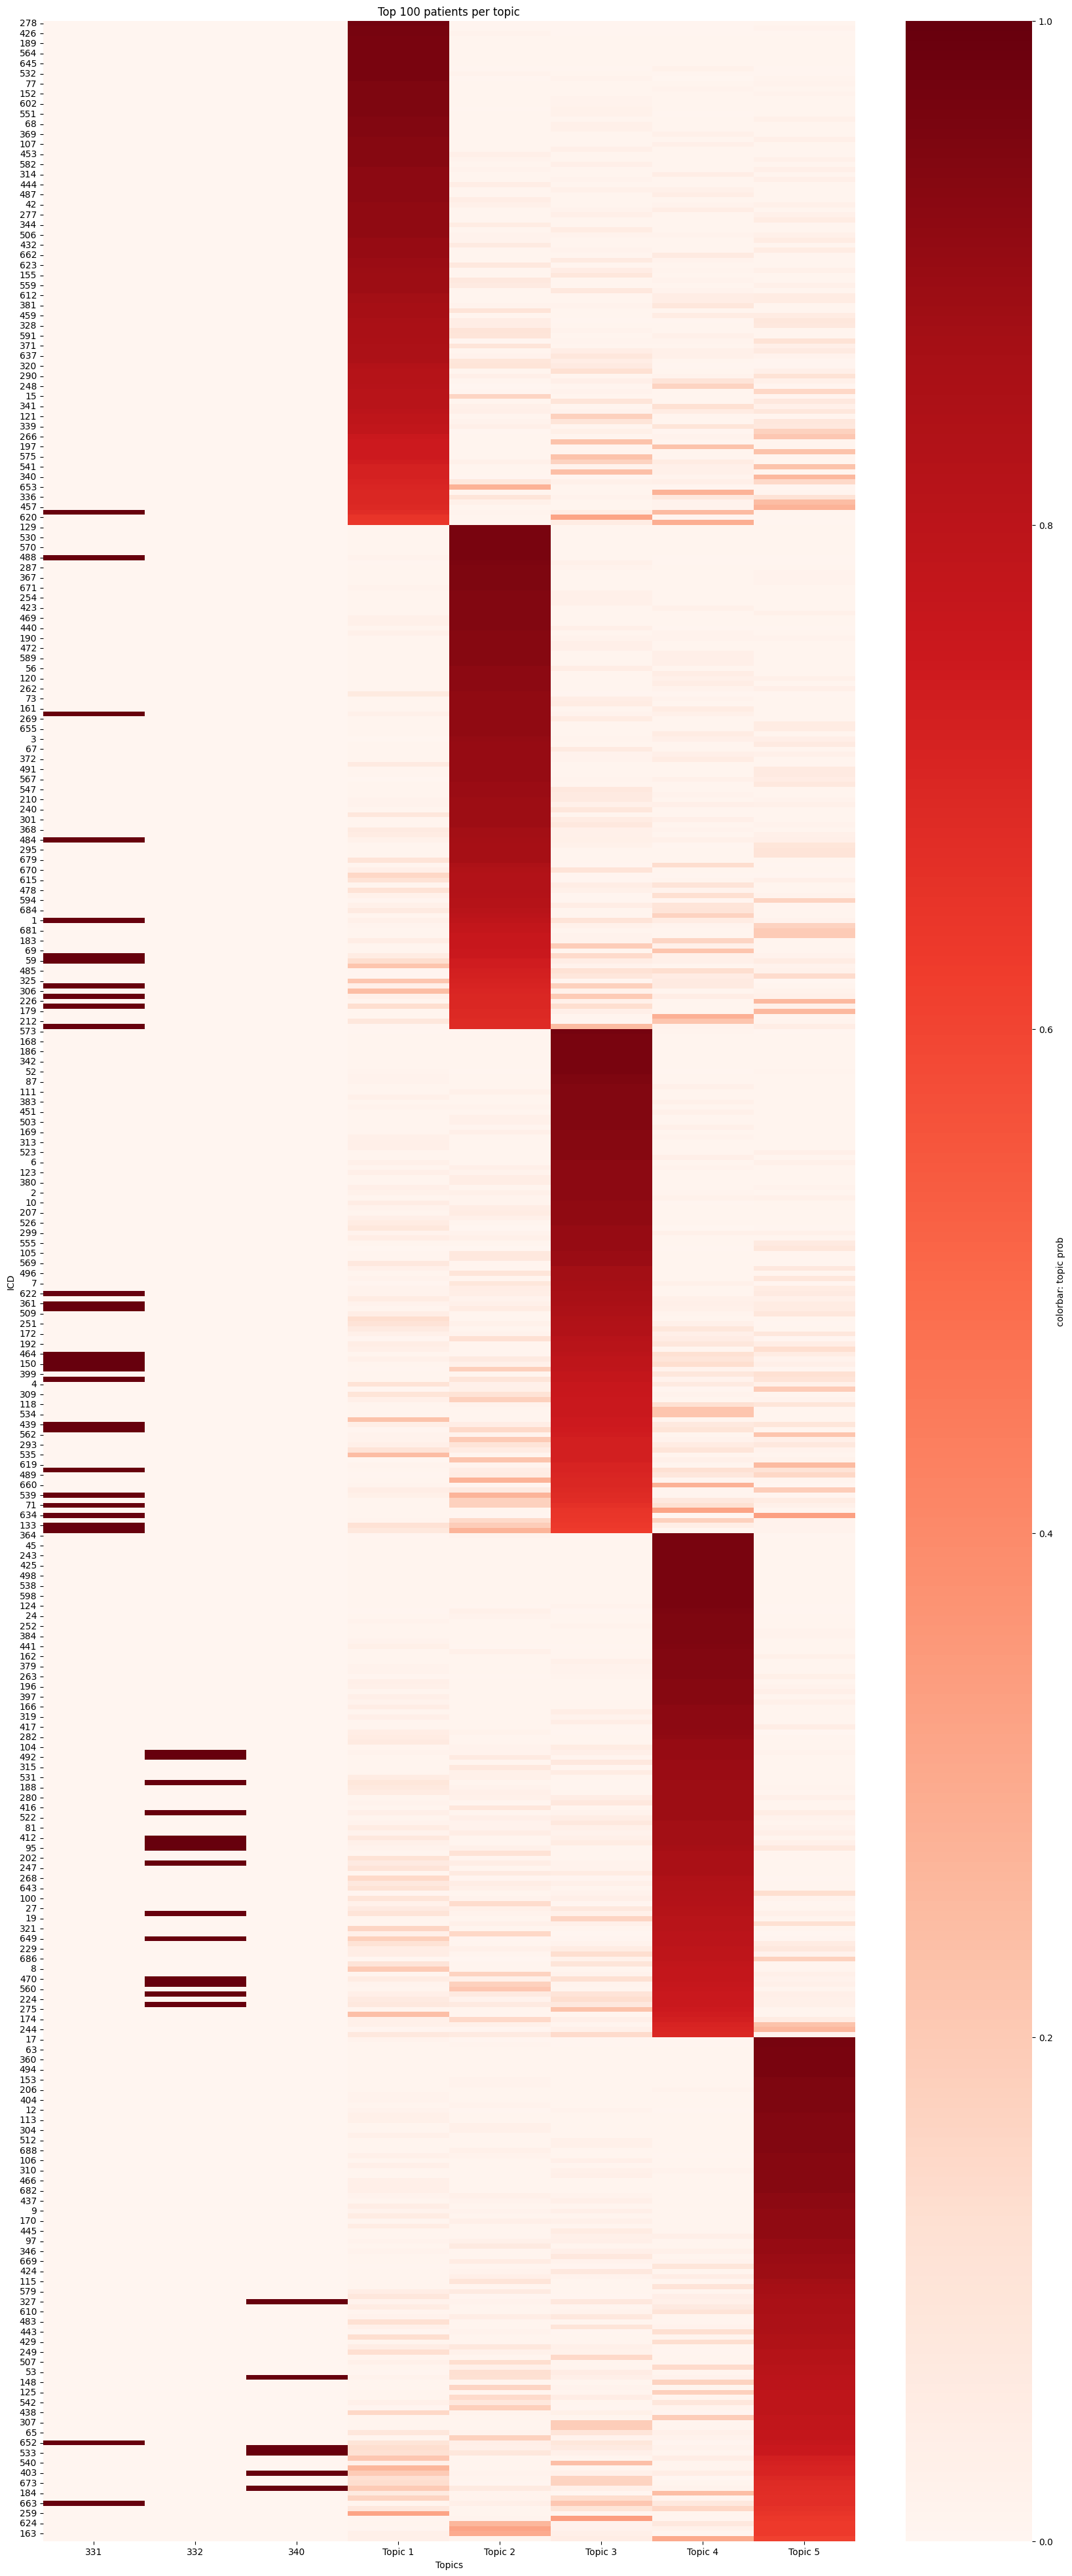

In [15]:
def get_top_patients_per_topic(icd_indicator_df, theta, top_n=100):
    topic_columns = ["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5"]
    theta_df = pd.DataFrame(theta, columns=topic_columns)
    theta_df = pd.concat([icd_indicator_df, theta_df], axis=1)

    top_patients_dfs = []
    for topic in topic_columns:
        top_patients_dfs.append(theta_df.nlargest(top_n, topic))

    return pd.concat(top_patients_dfs)

top_theta_df = get_top_patients_per_topic(icd_indicator_df, theta)

# Plotting
plt.figure(figsize=(20, 50))
sns.heatmap(top_theta_df, cmap="Reds", cbar_kws={'label': 'colorbar: topic prob'})
plt.xlabel('Topics')
plt.ylabel('ICD')
plt.title('Top 100 patients per topic')
plt.show()